In [41]:
import os, sys
import re
import numpy as np
import imageio as im
import pandas as pd
import cv2
from skimage.morphology import skeletonize
from skimage.util import invert
from IPython.display import Image
import matplotlib.pyplot as plt
from cv2 import imwrite
from cv_algorithms import grassfire
from cv_algorithms import thinning as ta
from cv_algorithms.morphology import difference_of_gaussian
from fil_finder import FilFinder2D
from astropy.io import fits
import astropy.units as u
cell_path = "individual_cells/"

In [152]:
def prune(img,b_thresh=40,sk_thresh=10):
    fil=FilFinder2D(img,mask=img)
    fil.preprocess_image(skip_flatten=True)
    fil.medskel()
    fil.analyze_skeletons(branch_thresh=b_thresh*u.pix, skel_thresh=sk_thresh*u.pix, prune_criteria='length')
    return fil.skeleton_longpath>0

In [153]:
all_the_cells = os.listdir(cell_path)

# Create a list that records the timepoints for every mask. 
time_list = []
# List of masks with associated timepoints and names
maskl = []
#list of skeletons made by thinning with associated timepoints
thinl = []
#list of skeletons made by guo_hall thinning algorithm with assocciated timepoints
ghtl = []
#list of skeletons made zhang-suen thinning algorithm with associated timepoints
zstl=[]
#list of skeletons made using the grassfire algorithm with associated timepoints
grasl=[]
#list of skeletons made using the grassfire algorithm with associated timepoints
dogl=[]
for item in os.listdir('algorithm_comparison'):
    if item[-3]=='p' and item[-2]=='n' and item[-1]=='g':
        os.remove('algorithm_comparison'+'/'+item)
for cell in all_the_cells:
    time = re.findall(r'\d+', cell)
    if time != []:
        #overwrite old skeletons in individual_cells
        '''
        for item in os.listdir(cell_path+cell+'\skeletons'):
            if item[-3]=='p' and item[-2]=='n' and item[-1]=='g':
                os.remove(cell_path+cell+'\skeletons'+'/'+item)
        '''
        time = time[0]
        time_list.append(int(time))
        im_path = cell_path + cell + '\masks'
        for mask_name in os.listdir(im_path):
            mask=im.imread(im_path+'/'+mask_name)[:,:,0]>0 #the cells mask (boolean array)
            thin=skeletonize(mask) #the masks skeleton from skimage (boolean array)
            thin = prune(thin*255)
            thin = invert (thin + invert(mask))
            ght = ta.guo_hall(mask.astype(np.uint8))>0 #the masks skeleton from the guo_hall algorithm (boolean array)
            ght=prune(ght*255)
            ght = invert (ght + invert(mask))
            zst = ta.zhang_suen(mask.astype(np.uint8))>0 # the masks skeleton from the zhang_shuen algorithm (boolean array)
            zst=prune(zst*255)
            zst = invert(zst + invert(mask))
            #gras = grassfire(mask.astype(np.uint8)) # the masks skeleton from the grassfire algorithm
            maskl.append([mask,time,int(mask_name[5:6])])
            thinl.append([thin,time,int(mask_name[5:6])])
            ghtl.append([ght,time,int(mask_name[5:6])])
            zstl.append([zst,time,int(mask_name[5:6])])
            #grasl.append([gras,time,int(mask_name[5:6])])
            imwrite('algorithm_comparison'+'/'+str(time)+'_'+mask_name[5:6]+'_skimage'+'.png',255*thin)
            imwrite('algorithm_comparison'+'/'+str(time)+'_'+mask_name[5:6]+'_guo_hall'+'.png',255*ght)
            imwrite('algorithm_comparison'+'/'+str(time)+'_'+mask_name[5:6]+'_zhang_suen'+'.png',255*zst)
            #imwrite('algorithm_comparison'+'/'+str(time)+'_'+mask_name[5:6]+'_grassfire'+'.png',gras.astype(np.uint8))

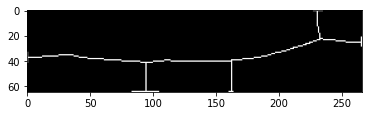

In [133]:
zst = zstl[0][0]*255
plt.imshow(zst,cmap=plt.cm.gray)

In [137]:
fil=FilFinder2D(zst,mask=zst)
fil.preprocess_image(skip_flatten=True)
fil.medskel()

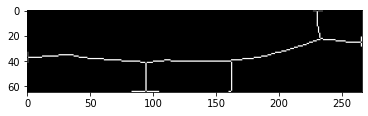

In [138]:
plt.imshow(fil.skeleton,cmap=plt.cm.gray)

In [139]:
fil.analyze_skeletons(skel_thresh=40*u.pix, prune_criteria='length')

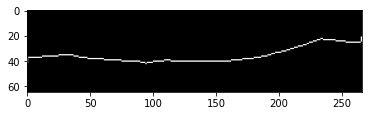

In [140]:
plt.imshow(fil.skeleton_longpath,cmap=plt.cm.gray)